# Clinical Trial Navigator

The purpose of of this program is to query the ClinicalTrials.gov database and return a formatted database file of clinical trials based on custom search criteria.

The database file will contain details around clinical trial design, protocol, indication, product, start/completion date, and outcome measures.

This database file will be used to conduct detailed analyses, i.e. to compare duration, trial sample size, endpoints used, and outcome performance for all phase 3 trials in a specific indication or in a specific drug class.

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import time
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

I used an object-oriented approach to design this Clinical Trial Navigator tool.  

I designed a Query class to draft the query that will be used to search the ClinicalTrials.gov API.  I pre-selected a list of field names I found to be of greatest interest (the API allows up to 25 field values per query), and the full list of field names can be found at https://clinicaltrials.gov/api/info/study_structure. The Query class also converts the JSON query result to a pandas dataframe, an easier format with which to perform analyses.

The Study class below represents individual clinical studies, and will be used to extract the various clinical trial criteria from the individual studies to allow for detailed analyses.

In [224]:
class Query:        # class to create a query from the clinicaltrials API that will house the list of clinical trials returned from the API, with detailed information for each
    
    def __init__(self, name = 'Query_1'):
        self.name = name
        self.study_tracker = []

    def build_query(self):
        query_terms = input('Enter the search query term: \n')
        query_tokenized = query_terms.split()
        
        field_values = ['NCTId', 'BriefTitle', 'Condition', 'Phase', 'StudyType',
                        'EnrollmentCount', 'StartDate', 'PrimaryCompletionDate', 'EligibilityCriteria', 'InterventionName', 
                        'ArmGroupInterventionName', 'ArmGroupDescription', 'InterventionArmGroupLabel', 'OutcomeMeasureType', 'OutcomeMeasureTitle',
                        'OutcomeMeasureDescription', 'OutcomeMeasureTimeFrame', 'OutcomeMeasurementValue', 'OutcomeMeasureUnitOfMeasure']
        
        max_rank = 1000
        
        
        url = 'https://clinicaltrials.gov/api/query/study_fields?expr='
        
        for i, word in enumerate(query_tokenized):
            if i is 0:
                url = url + word
            else:
                url = url + '+' + word
            
        url = url + '&fields='
        
        for i, word in enumerate(field_values):
            if i is 0:
                url = url + word
            else:
                url = url + '%2C' + word
        
        url = url + '&min_rnk=1&max_rnk=' + str(max_rank) + '&fmt=json'
        url = url.strip()
        self.url = url
        
        print('Querying 1,000 trials from clinicaltrials.gov with the following url...\n\n'+url)
        
    def build_study_table(self, url):
          
        ## convert the query result to pandas dataframe
        
        result = requests.get(url).json()
        result_list = [result for result in result['StudyFieldsResponse']['StudyFields'] if result['OutcomeMeasureType']]     #loop through the list and identify ONLY studies with outcome measures reported 
        df_master = json_normalize(result_list[0])      # initialize dataframe using JSON result

        try:
            for study in result_list[1:]:        # concatenate each study to the dataframe to generate master dataframe
                df = json_normalize(study)
                df_master = pd.concat([df_master, df], axis=0, ignore_index=True)
        except:
            pass
        
        df_master['NCTId'] = [df_master['NCTId'][i][0] for i in range(len(df_master['NCTId']))]
        df_master['BriefTitle'] = [df_master['BriefTitle'][i][0] for i in range(len(df_master['BriefTitle']))]
        df_master['Condition'] = [df_master['Condition'][i][0] for i in range(len(df_master['Condition']))]
        df_master['StudyType'] = [df_master['StudyType'][i][0] for i in range(len(df_master['StudyType']))]
        df_master['Phase'] = [df_master['Phase'][i][0] for i in range(len(df_master['Phase']))]
        df_master['EnrollmentCount'] = [df_master['EnrollmentCount'][i][0] for i in range(len(df_master['EnrollmentCount']))]
        df_master['StartDate'] = [df_master['StartDate'][i][0] for i in range(len(df_master['StartDate']))]
        df_master['PrimaryCompletionDate'] = [df_master['PrimaryCompletionDate'][i][0] for i in range(len(df_master['PrimaryCompletionDate']))]
        df_master['EligibilityCriteria'] = [df_master['EligibilityCriteria'][i][0] for i in range(len(df_master['EligibilityCriteria']))]
        
        #df_master['StartDate'] = pd.to_datetime(df_master['StartDate'])
        #df_master['PrimaryCompletionDate'] = pd.to_datetime(df_master['PrimaryCompletionDate'])
        
        self.df_master = df_master
        
        return self.df_master
    
    def get_url(self):
        return self.url

    def get_study_tracker(self):
        return self.study_tracker
    
    def get_df_master(self):
        return self.df_master
        

In [318]:
class Study:
    
    def __init__(self, query, nct_id):
        
        self.nct_id = nct_id
        self.entry = query.get_df_master()[query.get_df_master()['NCTId']==nct_id]
        self.df_outcomes = pd.DataFrame(columns=self.entry.columns)
        
        try:
            self.measures_per_outcome = len(self.entry['OutcomeMeasurementValue'][0])//len(self.entry['OutcomeMeasureTitle'][0])
        except:
            self.measures_per_outcome = 1
        
        if self.nct_id not in query.study_tracker:
            query.study_tracker.append(self.nct_id)
        
    def get_entry(self):
        return self.entry
    
    def get_indication(self):
        return [item for item in self.entry['Condition']][0]     # returns the first list item within the list of target

    def extract_outcomes(self):            #iterate thru all outcome measures, create a dataframe with all required info
        
        try:
            self.df_outcomes = self.df_outcomes.drop(columns=['Rank', 'Condition','BriefTitle', 'Phase', 'StudyType', 
                                                          'EnrollmentCount', 'StartDate', 'PrimaryCompletionDate', 'EligibilityCriteria', 
                                                          'InterventionName', 'ArmGroupInterventionName', 'ArmGroupDescription', 'InterventionArmGroupLabel'])
        except:
            pass
        
        for i, item in enumerate(self.entry['OutcomeMeasureType']):
                
            try:
                self.df_outcomes['OutcomeMeasureType'] = [item for item in self.entry['OutcomeMeasureType']][0]
            except:
                pass
            try:
                self.df_outcomes['OutcomeMeasureTitle'] = [item for item in self.entry['OutcomeMeasureTitle']][0]
            except:
                pass
            try:
                self.df_outcomes['OutcomeMeasureDescription'] = [item for item in self.entry['OutcomeMeasureDescription']][0]
            except:
                pass
            try:
                self.df_outcomes['OutcomeMeasureTimeFrame'] = [item for item in self.entry['OutcomeMeasureTimeFrame']][0]
            except:
                pass
            
            try:
                self.df_outcomes['OutcomeMeasureUnitOfMeasure'] = [item for item in self.entry['OutcomeMeasureUnitOfMeasure']][0]
            except:
                pass

                                        # maps correct number of outcome measures reported in the study
        beginning = 0
        increment = self.measures_per_outcome
       
        
        for i in range(len(self.df_outcomes)):
            try:
                self.df_outcomes['OutcomeMeasurementValue'][i] = self.entry['OutcomeMeasurementValue'][0][beginning:beginning+increment]
                beginning += increment
            except:
                pass
        
        self.df_outcomes['NCTId'] = [item for item in self.entry['NCTId']][0]
        
        return self.df_outcomes

I will now instantiate a new query for severe atopic dermatitis, or eczema, an inflammatory condition of the skin.

In [356]:
atopic_derm = Query()
atopic_derm.build_query()

Enter the search query term: 
severe atopic dermatitis
Querying 1,000 trials from clinicaltrials.gov with the following url...

https://clinicaltrials.gov/api/query/study_fields?expr=severe+atopic+dermatitis&fields=NCTId%2CBriefTitle%2CCondition%2CPhase%2CStudyType%2CEnrollmentCount%2CStartDate%2CPrimaryCompletionDate%2CEligibilityCriteria%2CInterventionName%2CArmGroupInterventionName%2CArmGroupDescription%2CInterventionArmGroupLabel%2COutcomeMeasureType%2COutcomeMeasureTitle%2COutcomeMeasureDescription%2COutcomeMeasureTimeFrame%2COutcomeMeasurementValue%2COutcomeMeasureUnitOfMeasure&min_rnk=1&max_rnk=1000&fmt=json


I see my query URL built using my Query class' build_query function.  Let's take a look at the clinical trials returned from this request.

In [359]:
atopic_derm_table = atopic_derm.build_study_table(atopic_derm.get_url())
atopic_derm_table.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:51: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,Rank,NCTId,BriefTitle,Condition,Phase,StudyType,EnrollmentCount,StartDate,PrimaryCompletionDate,EligibilityCriteria,InterventionName,ArmGroupInterventionName,ArmGroupDescription,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,12,NCT03054428,Efficacy and Safety of Dupilumab in Participan...,Moderate-to-Severe Atopic Dermatitis,Phase 3,Interventional,251,"March 21, 2017","April 4, 2018",Inclusion Criteria:\n\nMale or female ≥12 to <...,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]",[Participants received placebo matching dupilu...,"[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300...","[Primary, Primary, Secondary, Secondary, Secon...",[Percentage of Participants With Investigator'...,[IGA is an assessment scale used to determine ...,"[Baseline and Week 16, Baseline and Week 16, B...","[2.4, 17.9, 24.4, 8.2, 38.1, 41.5, -23.6, -64....","[Percentage of participants, Percentage of par..."
1,13,NCT03831191,A Study of LY3375880 in Adults With Moderate-t...,Atopic Dermatitis,Phase 2,Interventional,136,"February 12, 2019","February 27, 2020",Inclusion Criteria:\n\nParticipants must have ...,"[LY3375880, Placebo]","[Drug: LY3375880, Drug: LY3375880, Drug: LY337...",[Induction Period:\n\nParticipants received 50...,"[150 mg LY3375880, 50 mg LY3375880, 600 mg LY3...","[Primary, Secondary, Secondary, Secondary, Sec...",[Percentage of Participants Achieving Validate...,[vIGA-AD measures participants' overall severi...,"[Week 16, Week 16, Week 16, Week 16, Baseline,...","[9.5, 5.0, 5.9, 4.8, 19.0, 15.0, 23.5, 0.0, 4....","[Percentage of participants, Percentage of Par..."
2,14,NCT03334422,Study of Baricitinib (LY3009104) in Patients W...,Atopic Dermatitis,Phase 3,Interventional,615,"November 27, 2017","December 12, 2018",Inclusion Criteria:\n\nHave been diagnosed wit...,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baric...",[4mg Baricitinib administered orally once dail...,"[1mg Baricitinib, 2mg Baricitinib, 4 Milligram...","[Primary, Secondary, Secondary, Secondary, Sec...",[Percentage of Participants Achieving Investig...,[The IGA measures the investigator's global as...,"[16 Weeks, 16 Weeks, 16 Weeks, 16 Weeks, Basel...","[4.5, 10.6, 13.8, 4.5, 8.8, 6.1, 12.8, 17.9, 2...","[percentage of participants, percentage of par..."
3,15,NCT01785602,Efficacy and Safety Study of QAW039 in the Tre...,Atopic Dermatitis,Phase 2,Interventional,103,June 2013,November 2014,Key Inclusion Criteria:\n\nPresence of atopic ...,"[QAW039, Placebo]","[Drug: QAW039, Drug: Placebo]",[Participants received QAW039 450 mg daily by ...,"[QAW039, Placebo]","[Primary, Secondary]",[Change From Baseline in Eczema Area and Sever...,[Investigators assessed presence and severity ...,"[Baseline, 12 weeks, Baseline, 4 weeks, 8 weeks]","[-8.65, -6.95, -6.22, -5.89, -7.49, -5.61]","[Score on a scale, Score on a scale]"
4,16,NCT03443024,A Study of Lebrikizumab (LY3650150) in Partici...,Atopic Dermatitis,Phase 2,Interventional,280,"January 30, 2018","February 7, 2019","Inclusion Criteria:\n\nMale or female, 18 year...","[Lebrikizumab, Placebo]","[Biological: Lebrikizumab, Drug: Placebo, Biol...",[125 mg Lebrikizumab administered subcutaneous...,[125 milligrams (mg) Lebrikizumab - Every 4 We...,"[Primary, Secondary, Secondary, Secondary, Sec...",[Percent Change From Baseline in Eczema Area a...,[The EASI assesses objective physician estimat...,"[Baseline, Week 16, Week 16, Week 16, Week 16,...","[-62.34, -69.21, -72.09, -41.12, 43.3, 56.1, 6...","[percent change, percentage of participants, p..."


In [360]:
atopic_derm_table.shape

(112, 20)

There are 112 clinical trials returned from our query.  (NOTE: my query is ONLY returning studies that have outcome measures reported on ClinicalTrials.gov).  I will narrow this down a bit more to only Phase 3 trials, which represent the pivotal trial.

In [361]:
# narrow down to only phase 3 trials

ad_phase_3 = atopic_derm_table[atopic_derm_table['Phase'].str.lower() == 'phase 3'].reset_index().drop(columns='index')
ad_phase_3.head()

,Rank,NCTId,BriefTitle,Condition,Phase,StudyType,EnrollmentCount,StartDate,PrimaryCompletionDate,EligibilityCriteria,InterventionName,ArmGroupInterventionName,ArmGroupDescription,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,12,NCT03054428,Efficacy and Safety of Dupilumab in Participan...,Moderate-to-Severe Atopic Dermatitis,Phase 3,Interventional,251,"March 21, 2017","April 4, 2018",Inclusion Criteria:\n\nMale or female ≥12 to <...,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]",[Participants received placebo matching dupilu...,"[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300...","[Primary, Primary, Secondary, Secondary, Secon...",[Percentage of Participants With Investigator'...,[IGA is an assessment scale used to determine ...,"[Baseline and Week 16, Baseline and Week 16, B...","[2.4, 17.9, 24.4, 8.2, 38.1, 41.5, -23.6, -64....","[Percentage of participants, Percentage of par..."
1,14,NCT03334422,Study of Baricitinib (LY3009104) in Patients W...,Atopic Dermatitis,Phase 3,Interventional,615,"November 27, 2017","December 12, 2018",Inclusion Criteria:\n\nHave been diagnosed wit...,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baric...",[4mg Baricitinib administered orally once dail...,"[1mg Baricitinib, 2mg Baricitinib, 4 Milligram...","[Primary, Secondary, Secondary, Secondary, Sec...",[Percentage of Participants Achieving Investig...,[The IGA measures the investigator's global as...,"[16 Weeks, 16 Weeks, 16 Weeks, 16 Weeks, Basel...","[4.5, 10.6, 13.8, 4.5, 8.8, 6.1, 12.8, 17.9, 2...","[percentage of participants, percentage of par..."
2,19,NCT03334396,A Study of Baricitinib (LY3009104) in Patients...,Atopic Dermatitis,Phase 3,Interventional,660,"November 23, 2017","December 6, 2018",Inclusion Criteria:\n\nHave been diagnosed wit...,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baric...",[4 mg Baricitinib administered orally once dai...,"[1 mg Baricitinib, 1 mg Baricitinib Maximum Ex...","[Primary, Secondary, Secondary, Secondary, Sec...",[Percentage of Participants Achieving Investig...,[The IGA measures the investigator's global as...,"[16 Weeks, 16 Weeks, 16 Weeks, 16 Weeks, Basel...","[4.8, 11.4, 16.8, 4.8, 11.8, 8.8, 17.3, 18.7, ...","[percentage of participants, percentage of par..."
3,20,NCT03435081,A Study of Baricitinib (LY3009104) in Adult Pa...,Atopic Dermatitis,Phase 3,Interventional,440,"February 20, 2018","December 9, 2019",Inclusion Criteria:\n\nHave a diagnosis of ato...,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baric...",[2 mg Baricitinib administered orally every da...,"[1 mg Baricitinib, 2 milligram (mg) Baricitini...","[Primary, Secondary, Secondary, Secondary, Sec...",[Percentage of Participants Achieving Eczema A...,[The EASI assesses objective physician estimat...,"[Week 16, Week 16, Week 16, Week 16, Baseline,...","[8.2, 29.5, 5.4, 12.9, 24.0, 8.2, 12.9, 3.4, 7...","[percentage of participants, percentage of par..."
4,36,NCT03733301,A Study of Baricitinib (LY3009104) in Combinat...,Atopic Dermatitis,Phase 3,Interventional,329,"November 16, 2018","July 29, 2019",Inclusion Criteria:\n\nHave been diagnosed wit...,"[Baricitinib, Topical corticosteroid, Placebo]","[Drug: Baricitinib, Drug: Topical corticostero...",[4 mg Baricitinib administered orally once dai...,"[2 mg Baricitinib, 4 Milligram (mg) Baricitini...","[Primary, Secondary, Secondary, Secondary, Sec...",[Percentage of Participants Achieving Investig...,[The IGA measures investigators global assessm...,"[Week 16, Week 16, Week 16, Baseline, Week 16,...","[14.7, 23.9, 30.6, 22.9, 43.1, 47.7, 13.8, 16....","[percentage of participants, percentage of par..."


In [362]:
ad_phase_3.shape

(31, 20)

31 studies is a bit more manageable than 112.

I will now instantiate a few Study objects to test the outcome measure extraction functionality.  I will just take the first 3 studies returned in my atopic dermatitis Query.

In [364]:
study_1 = Study(atopic_derm, ad_phase_3['NCTId'][0])
study_1.get_entry()

,Rank,NCTId,BriefTitle,Condition,Phase,StudyType,EnrollmentCount,StartDate,PrimaryCompletionDate,EligibilityCriteria,InterventionName,ArmGroupInterventionName,ArmGroupDescription,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,12,NCT03054428,Efficacy and Safety of Dupilumab in Participan...,Moderate-to-Severe Atopic Dermatitis,Phase 3,Interventional,251,"March 21, 2017","April 4, 2018",Inclusion Criteria:\n\nMale or female ≥12 to <...,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]",[Participants received placebo matching dupilu...,"[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300...","[Primary, Primary, Secondary, Secondary, Secon...",[Percentage of Participants With Investigator'...,[IGA is an assessment scale used to determine ...,"[Baseline and Week 16, Baseline and Week 16, B...","[2.4, 17.9, 24.4, 8.2, 38.1, 41.5, -23.6, -64....","[Percentage of participants, Percentage of par..."


In [365]:
study_2 = Study(atopic_derm, ad_phase_3['NCTId'][1])
study_2.get_entry()

,Rank,NCTId,BriefTitle,Condition,Phase,StudyType,EnrollmentCount,StartDate,PrimaryCompletionDate,EligibilityCriteria,InterventionName,ArmGroupInterventionName,ArmGroupDescription,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
2,14,NCT03334422,Study of Baricitinib (LY3009104) in Patients W...,Atopic Dermatitis,Phase 3,Interventional,615,"November 27, 2017","December 12, 2018",Inclusion Criteria:\n\nHave been diagnosed wit...,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baric...",[4mg Baricitinib administered orally once dail...,"[1mg Baricitinib, 2mg Baricitinib, 4 Milligram...","[Primary, Secondary, Secondary, Secondary, Sec...",[Percentage of Participants Achieving Investig...,[The IGA measures the investigator's global as...,"[16 Weeks, 16 Weeks, 16 Weeks, 16 Weeks, Basel...","[4.5, 10.6, 13.8, 4.5, 8.8, 6.1, 12.8, 17.9, 2...","[percentage of participants, percentage of par..."


In [366]:
study_3 = Study(atopic_derm, ad_phase_3['NCTId'][14])
study_3.get_entry()

,Rank,NCTId,BriefTitle,Condition,Phase,StudyType,EnrollmentCount,StartDate,PrimaryCompletionDate,EligibilityCriteria,InterventionName,ArmGroupInterventionName,ArmGroupDescription,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
28,91,NCT03131648,Tralokinumab Monotherapy for Moderate to Sever...,Atopic Dermatitis,Phase 3,Interventional,802,"May 30, 2017","August 7, 2018",Inclusion Criteria:\n\nAge 18 and above\nDiagn...,"[Tralokinumab, Placebo]","[Drug: Tralokinumab, Drug: Placebo, Drug: Tral...",[Week 0 to Week 16:\n\nTwo subcutaneous (SC) i...,"[Initial treatment period - Tralokinumab Q2W, ...","[Primary, Primary, Secondary, Secondary, Secon...",[Subjects With Investigator's Global Assessmen...,[The IGA is an instrument used in clinical tri...,"[At Week 16, At Week 16, Week 0 to Week 16, We...","[95, 14, 150, 25, 119, 20, -25.2, -14.7, -7.1,...","[Participants, Participants, Participants, uni..."


It seems my Study classes are functioning properly so far - let's see if my Query study tracker is capturing the studies created thus far.

In [367]:
atopic_derm.get_study_tracker()

['NCT03054428', 'NCT03334422', 'NCT03131648']

So far so good - my studies are being tracked within my atopic_derm query.  Now I want to take a look at the outcome measures reported in the 3 studies I instantiated.

Let's test out the extract_outcomes function to see if I can identify all the different primary and secondary endpoints reporte in each study.  This will come in handy when I compare clinical trials in a later version of this notebook.

In [369]:
outcomes1 = study_1.extract_outcomes()
outcomes1.head()

,NCTId,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,NCT03054428,Primary,Percentage of Participants With Investigator's...,IGA is an assessment scale used to determine s...,Baseline and Week 16,"[2.4, 17.9, 24.4]",Percentage of participants
1,NCT03054428,Primary,Percentage of Participants With Eczema Area an...,The EASI score was used to measure the severit...,Baseline and Week 16,"[8.2, 38.1, 41.5]",Percentage of participants
2,NCT03054428,Secondary,Percent Change From Baseline in EASI Score at ...,The Eczema Area and Severity Index (EASI) scor...,Baseline and Week 16,"[-23.6, -64.8, -65.9]",Percent change
3,NCT03054428,Secondary,Percent Change From Baseline in Weekly Average...,Peak Pruritus NRS is an assessment tool used b...,Baseline and Week 16,"[-19.0, -45.5, -47.9]",Percent change
4,NCT03054428,Secondary,Percentage of Participants With Improvement (R...,Peak Pruritus NRS is an assessment tool used b...,Baseline to Week 16,"[9.4, 38.6, 48.8]",Percentage of participants


In [370]:
outcomes2 = study_2.extract_outcomes()
outcomes2.head()

,NCTId,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,NCT03334422,Primary,Percentage of Participants Achieving Investiga...,The IGA measures the investigator's global ass...,16 Weeks,NaN,percentage of participants
1,NCT03334422,Secondary,Percentage of Participants Achieving IGA of 0 ...,The IGA measures the investigator's global ass...,16 Weeks,NaN,percentage of participants
2,NCT03334422,Secondary,Percentage of Participants Achieving Eczema Ar...,The EASI assesses objective physician estimate...,16 Weeks,NaN,percentage of participants
3,NCT03334422,Secondary,Percentage of Participants Achieving EASI90,The EASI assesses objective physician estimate...,16 Weeks,NaN,percentage of participants
4,NCT03334422,Secondary,Percent Change From Baseline on EASI Score,The EASI assesses objective physician estimate...,"Baseline, 16 Weeks",NaN,Percent Change


In [371]:
outcomes3 = study_3.extract_outcomes()
outcomes3.head()

,NCTId,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,NCT03131648,Primary,Subjects With Investigator's Global Assessment...,The IGA is an instrument used in clinical tria...,At Week 16,NaN,Participants
1,NCT03131648,Primary,Subjects Achieving at Least 75% Reduction in E...,The EASI is a validated measure used in clinic...,At Week 16,NaN,Participants
2,NCT03131648,Secondary,Reduction of Worst Daily Pruritus Numeric Rati...,Subjects will assess their worst itch severity...,Week 0 to Week 16,NaN,Participants
3,NCT03131648,Secondary,Change in Scoring Atopic Dermatitis (SCORAD) F...,The SCORAD is a validated tool to evaluate the...,Week 0 to Week 16,NaN,units on a scale
4,NCT03131648,Secondary,Change in Dermatology Life Quality Index (DLQI...,The Dermatology Life Quality Index (DLQI) is a...,Week 0 to Week 16,NaN,units on a scale


It looks like all my outcomes are being extracted as expected.  In the next version of this notebook I will aggregate the various endpoints used in the clinical trial group returned from the query for the purposes of comparing endpoints across trials and in the aggregate.

Below is an illustrative example of one type of analysis I will be able to perform in the next iteration of this notebook.

In [372]:
outcome_tracker = {}

def outcome_track(outcome_list, track_dict):  # df_initial['OutcomeMeasureTitle'][0]  runs on a single column entry (1 study)
    
    for outcome in outcome_list:
        if outcome in track_dict.keys():
            track_dict[outcome] += 1
        else:
            track_dict[outcome] = 1

for study_outcome in ad_phase_3['OutcomeMeasureTitle']:
    outcome_track(study_outcome, outcome_tracker)

In [376]:
outcome_tracker_df = pd.Series(outcome_tracker).to_frame('Frequency').reset_index().sort_values(by='Frequency', ascending=False)
outcome_tracker_df.head(20)

,index,Frequency
23,Percentage of Participants Achieving EASI90,5
25,Percentage of Participants Achieving SCORing A...,5
43,Percentage of Participants Achieving Investiga...,5
40,Change From Baseline on the Work Productivity ...,5
36,Change From Baseline in the Total Score of the...,5
35,Percent Change From Baseline in Itch NRS,5
34,Percentage of Participants Developing Skin Inf...,5
33,Change From Baseline in Body Surface Area (BSA...,5
32,Percentage of Participants Achieving SCORAD90,5
31,Change From Baseline in SCORAD,5


Text(0.5, 0, 'Outcome Measure')

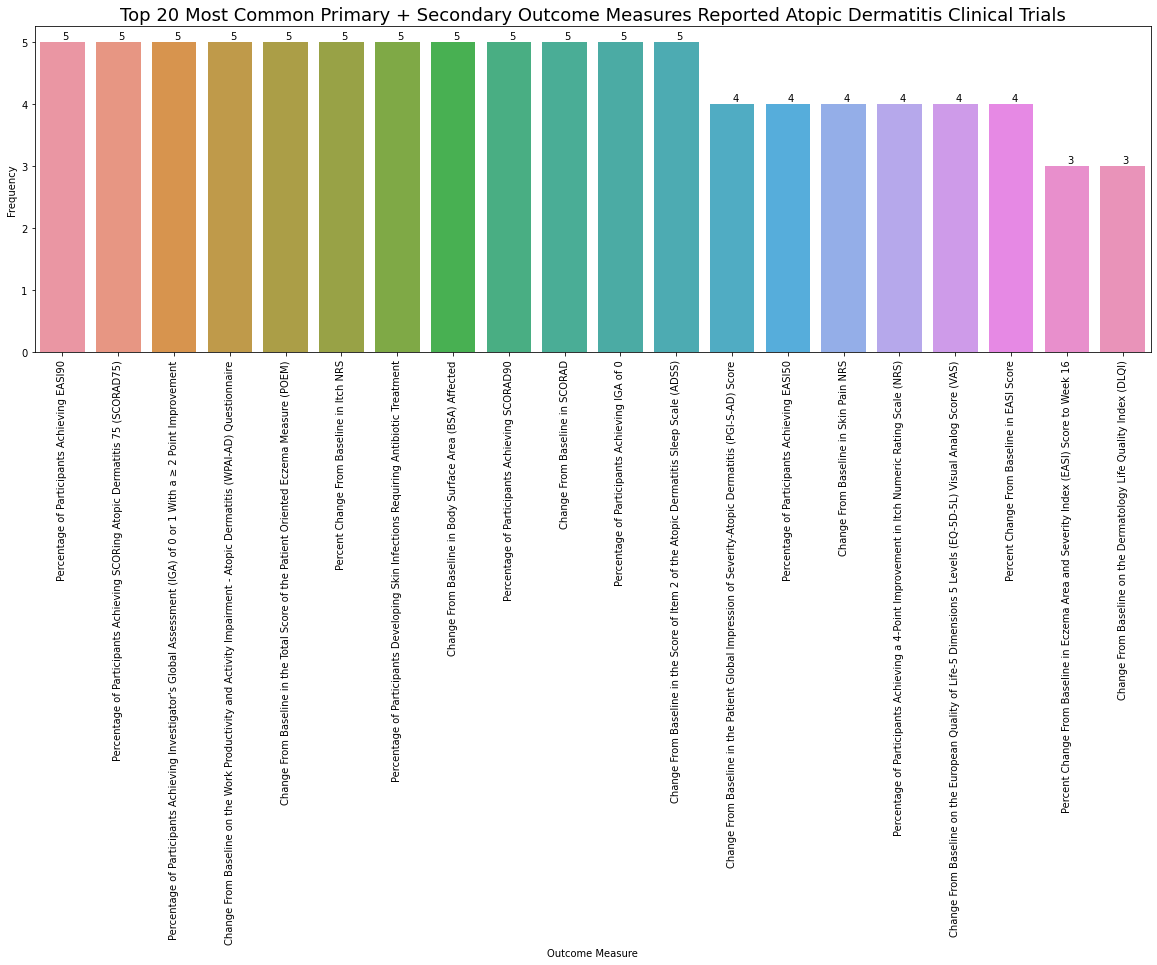

In [391]:
fig = plt.figure(figsize=[20,6])
ax = sns.barplot(data=outcome_tracker_df.head(20), x='index', y='Frequency', estimator=sum, ci=None)
for item in ax.get_xticklabels():
    item.set_rotation(90)
for p in ax.patches:
    ax.text(x = p.get_x()+(p.get_width()/2),y = p.get_height()+0.05,s = '{}'.format(p.get_height(),ha = 'center'))

ax.set_title('Top 20 Most Common Primary + Secondary Outcome Measures Reported Atopic Dermatitis Clinical Trials', fontsize=18)
ax.set_xlabel('Outcome Measure')